## Predicting heart disease using machine learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes

We are going to take the following approach: 

1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modeling
6. Experimentation

## 1. Problem Definition

In a statement, 
> Given clinical paramaters about a patient, can we predict whether or not they have heart disease? 

## 2.  Data 

The original data came from the Cleavland Data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

Dataset can also be found on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

## 3. Evaluation 

> If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we will pursue the project. 

## 4. Features

This is where you will get different informationn about each othe feature in your data

**Create data dictionary**

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [23]:
## Centerized Matplot Figure
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


# Libraries

In [22]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

## Function

In [103]:
# Annotated Bar Graphs
def plot_bar_graph(x, y, xlabel, ylabel, title):
    """
    Annotated Bar graphs
    x = data on the x axis of the bar
    y = data on the y axis of the bar
    xlabel = Label the x-axis
    ylabel = Label the y-axis
    title = Title the graph
    """
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x, y)
    names = sns.barplot(x, y)
    for p in names.patches: 
        names.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9),
                   textcoords = 'offset points')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

## Load the Data

In [25]:
df = pd.read_csv("data/heart disease.csv")
df.shape # (rows, columns)

(303, 14)

In [26]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


## Exploratory Data Analysis

1. What questions are we trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What is missing from from data and how do we deal with it?
4. Where are the outliers and why should you care about them?
5. How can we add, change or remove feature to get more of the data?


## Target Column- have disease or not (1=yes, 0=no) (= the predicted attribute).

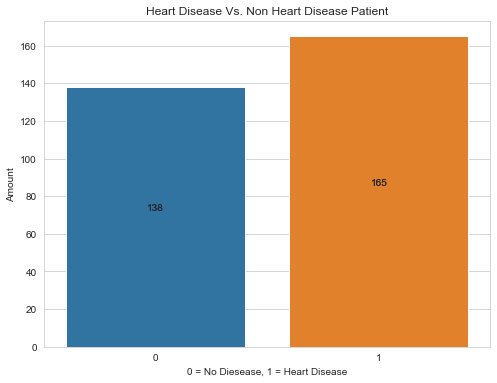

In [27]:
# How many target do we have
plot_bar_graph(x=df["target"].value_counts().keys().tolist(), 
               y =  df["target"].value_counts().tolist(),
               xlabel = "0 = No Diesease, 1 = Heart Disease",
               ylabel = "Amount",
               title = "Heart Disease Vs. Non Heart Disease Patient");

So we have 165 examples where someone has heart diseases based on their health parameters and 138 examples where someone does not have heart disease. We think that this is a relatively balanced problem –– meaning we have quite a similar amount in both classes. That's a Balanced classification problem

There is no missing value in this heart diseases data set therefore, we do not have to do anything about the missing values. However, if we are still trying to find out more about how data frankly might do we use the following method to see some numberical values about all of our columns.

In [28]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


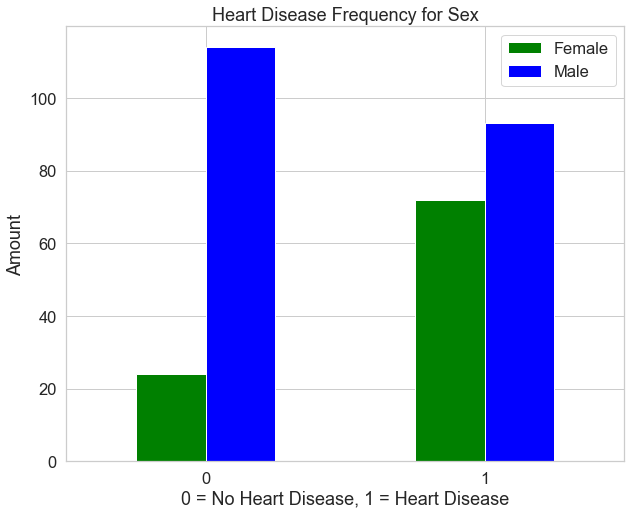

In [113]:
## Compare target column with sex column
pd.crosstab(df.target, df.sex).plot(kind="bar",color = ["green", "blue"], figsize=(10,8))
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("0 = No Heart Disease, 1 = Heart Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation = 0);

In [106]:
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


** What can we infer from this?

> Since there are about 100 women and 72% of the entire woman have a positive value of heart disease being present, we can predict that if the participant is a woman, she has heart desease based on our data. There are about 200 male with around half indicating presence of heart disease. So if the participant is male, we might predict that around half the time he will be a heart disease patient based on this data. 

> Now if we average 72% and 50%, we get about 62.5%. It means that based on this data a random participant whether male or female will have 62.5% chance of having heart disease.  

## Age vs. Max Heart Rate for Heart Disease

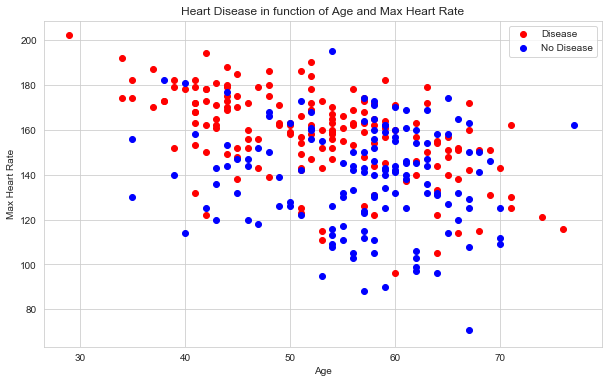

In [32]:
# Create a figure
plt.figure(figsize=(10,6))
# Scatter with positive example
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c = "red");
# Scatter with negative example
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c = "blue")
# Add some helful information
plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No Disease"]);

Based on the figure, we conclude that there is kind of a downward trend. The youngest someone is the higher the heart rate. 

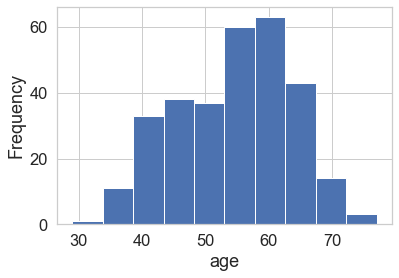

In [121]:
# Check the distribution of the age column with a histogram
df["age"].plot.hist()
plt.xlabel("age");

We see that the age for most of our population is around the big mid gap. We do not have that many around the 30 years old age or past 80. The majority of our dataset are within 50 to 60 range. 

## Does chest pain lead someone having heart disease? 

cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease


In [34]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


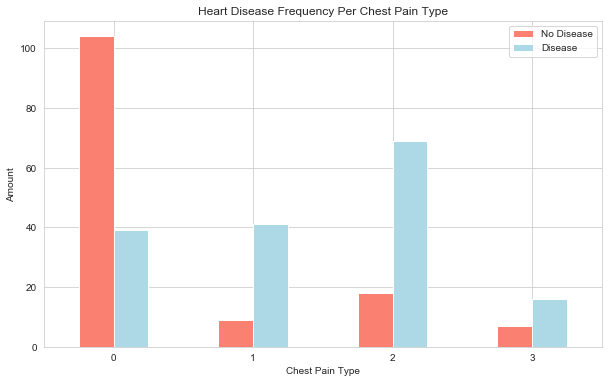

In [35]:
# Make the crosstab more visual
pd.crosstab(df.cp, df.target).plot(kind = "bar", 
                                   figsize = (10,6),
                                   color = ["salmon", "lightblue"])
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation = 0);

Based on this bar graph we conclude that chest pain type has way more accounts with the heart disease.

## Corrolation between Independent Variables and Dependent Variable (target column)

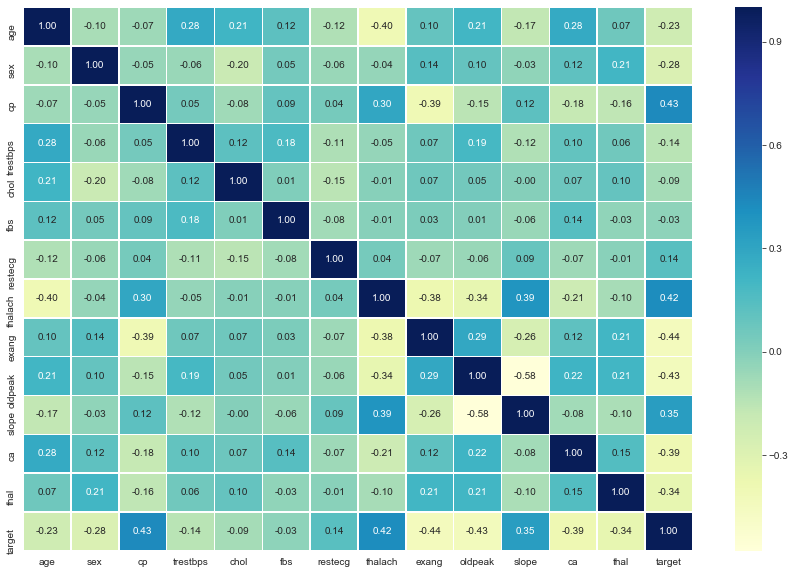

In [36]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, 
                 annot = True,
                 linewidth = 0.5,
                 fmt = ".2f", cmap="YlGnBu");

## 5. Modeling

In [38]:
## Split data into X and y
X = df.drop("target", axis = 1)
y = df["target"]

In [39]:
## Split data into train and test set
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)

Now we have splitted our data into train and test sets, We will construct our machine learning model by training it (find the patterns) on the training set and test (use the pattern) on the test set.

We are going to try three different machine learning models: 
> 1. Logistic Regression
> 2. K-Nearest Neighbors Classifiers
> 3. Random Forest Classifier

In [97]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=10000),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(n_estimators = 100)}

In [126]:
models_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
models_score = pd.DataFrame(models_scores, index = [0])
models_score

,Logistic Regression,KNN,Random Forest
0,0.885246,0.688525,0.836066


### Model Comparison

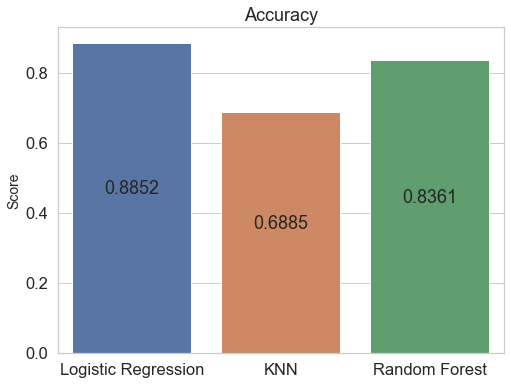

In [127]:
#Visualize the model comparison
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
models_score = sns.barplot(data=models_score)
for p in models_score.patches:
    models_score.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("Score", size=14)
plt.title("Accuracy");

Now we have got a baseline model ... and we know a model's first prediction are not always what we should based our next steps off. What should we do? 

Let's look at the following: 

* Hyperparameter tuning
* Feature importance
* Confusion Matrix
* Cross-validation
* Precision
* Recall
* Classification report
* ROC curve
* Area under the curve (AUC)

### Hyperparameter tuning

In [128]:
## Let's tune KNN
train_scores = []
test_scores = []

## Create a list of different value for n_neighbors
neighbors = range(1,21)

## Set up KNN instance
knn = KNeighborsClassifier()

## Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors = i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    #Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data :  75.41%


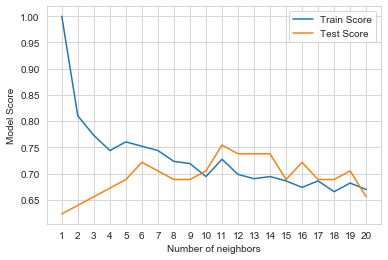

In [46]:
plt.plot(neighbors, train_scores, label = "Train Score")
plt.plot(neighbors, test_scores, label = "Test Score")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model Score")
plt.legend()
print(f"Maximum KNN score on the test data : {max(test_scores)*100: .2f}%")

## Hyperparameter tuning with RandomizedSearchV

We are going to tune:
* LogisticRegression()
* RandomForestClassifier()

... using RandomizedSearchCV

In [47]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C" : np.logspace(-4,4,20),
                "solver": ["liblinear"]}

In [48]:
# Tune LogisticRegression
np.random.seed(42)

# Setup random hyperparameter search for Logistic Regression
rs_log_reg_grid = RandomizedSearchCV(estimator = LogisticRegression(), 
                                     param_distributions=log_reg_grid,
                                     cv = 5,
                                     n_iter=20,
                                     verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [49]:
# Find the best hyperparameters
rs_log_reg_grid.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [50]:
# Evaluate the Randomized Search for LogisticRegression model
rs_log_reg_grid.score(X_test, y_test)

rs_log_reg_grid.score(X_test, y_test)

0.8852459016393442

### Lets now tune RandomForestClassifier()...

In [99]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

In [100]:
# Tune RandomForestClassifier
np.random.seed(42)
# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                                     param_distributions=rf_grid,
                                     cv = 5,
                                     n_iter=20,
                                     verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [53]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [54]:
# Evaluate the Randomized Search RandomForestClassifier 
rs_rf.score(X_test, y_test)

0.8688524590163934

## Hyperparameter Tunig with GridSearchCV

Since our LogisticRegression model provides the best scores so far, we will try and improve them again using GridSearchCV...

In [55]:
## Different hyperparameter for our LogisticRegression model
log_reg_grid = {"C" : np.logspace(-4,4,100),
                "solver": ["liblinear"]}

# Setup random hyperparameter search for Logistic Regression
gs_log_reg_grid = GridSearchCV(LogisticRegression(),
                               param_grid=log_reg_grid,
                               cv = 5,
                               verbose=True)

# Fit grid hyperparameter search model
gs_log_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.0s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.848035...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [56]:
# Check the best hypeerparameters
gs_log_reg_grid.best_params_

{'C': 0.20565123083486536, 'solver': 'liblinear'}

In [57]:
# Evaluate the Randomized Search Logistic Regression
gs_log_reg_grid.score(X_test, y_test)

0.8852459016393442

In [58]:
scoreTable =pd.DataFrame({"Model Original Score": pd.Series(list(model_scores.values()), 
                                index = ["Logistic Regression", "KNN", "Random Forest Classifier"]),
             
             
             "KNN Tuning": pd.Series(["N/A", max(test_scores), "N/A"], 
                                index = ["Logistic Regression", "KNN", "Random Forest Classifier"]),
             
             
             "RandomizedSearchCV": pd.Series([rs_log_reg_grid.score(X_test, y_test), "N/A", 
                                                           rs_rf.score(X_test, y_test)],
                                index = ["Logistic Regression", "KNN", "Random Forest Classifier"]),
             
             "GridSearchCV": pd.Series([gs_log_reg_grid.score(X_test, y_test), "N/A", 
                                                           "N/A"],
                                index = ["Logistic Regression", "KNN", "Random Forest Classifier"]),
            })

scoreTable

,Model Original Score,KNN Tuning,RandomizedSearchCV,GridSearchCV
Logistic Regression,0.885246,N/A,0.885246,0.885246
KNN,0.688525,0.754098,N/A,N/A
Random Forest Classifier,0.836066,N/A,0.868852,N/A


## Evaluating our tuned machine learning classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F-1 score

... and use cross-validation where possible

To make comparison and evaluate our trained model, first we make predictions.


In [59]:
# Make prediction with tuned model
y_pred = gs_log_reg_grid.predict(X_test)
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [60]:
y_test

179    0
228    0
111    1
246    0
60     1
      ..
249    0
104    1
300    0
193    0
184    0
Name: target, Length: 61, dtype: int64

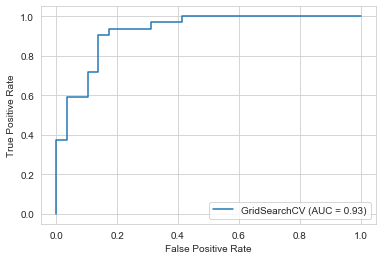

In [61]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg_grid, X_test, y_test);

In [62]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[25  4]
 [ 3 29]]


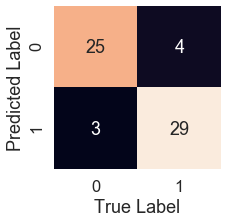

In [63]:
# Visualization of Confusion Matrix
sns.set(font_scale= 1.5)
def plot_conf_mat(y_test, y_pred):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True,
                    cbar= False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

plot_conf_mat(y_test, y_pred)

We see that the model gets confused so predicts the wrong label relatively the same across both classes. In essence, there are four occassions where the model predicted 0 when someone do not have heart disease when they should have been predicted as 1. This is called `False negative` (model predicts 0 when truth is 1). Furthermore, we have 3 instances where the mdoel predicts 1 (someone does have heart disease) when they actually don't. This is called `False positives` (model predict 1 when truth is 0)


   Note: In reality we want to avoid both `False negative` and `False positives` especially when working with severe heart disease problem. We do not want to predict heart disease of a patient when it is not present or vice versa. Therefore, when building a model we want to consider wether False negative is worse or False positives is worse. A perfect model would have none of these but in reality we recive some sort of this types.
   
   
 ## Classification Report 

In [64]:
print(classification_report(y_test, y_pred, target_names = ['No Disease 0', 'Heart Disease 1']))

                 precision    recall  f1-score   support

   No Disease 0       0.89      0.86      0.88        29
Heart Disease 1       0.88      0.91      0.89        32

       accuracy                           0.89        61
      macro avg       0.89      0.88      0.88        61
   weighted avg       0.89      0.89      0.89        61



## Calculate Evaluation metric using cross-validation

In [65]:
# Check best hyperparmeter
gs_log_reg_grid.best_params_

{'C': 0.20565123083486536, 'solver': 'liblinear'}

In [66]:
# Create a new classifier with best parameters
clf = LogisticRegression(C= 0.20565123083486536, 
                         solver ='liblinear')

In [67]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf, X, y, cv=5, scoring = "accuracy")
cv_acc = np.mean(cv_acc)
# Cross-validated precision
cv_precision = cross_val_score(clf, X, y, cv=5, scoring = "precision")
cv_precision = np.mean(cv_precision)
# Cross-validated f1
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring = "f1")
cv_f1 = np.mean(cv_f1)
# Cross-validated recall
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_recall = np.mean(cv_recall)
# Cross Validated Classification Metrics DataFrame
cv_metric_df = pd.DataFrame({"Accuracy": cv_acc,
                             "Precision": cv_precision,
                             "Recall": cv_recall,
                             "F1-Score": cv_f1},
                         index = [0])
cv_metric_df

,Accuracy,Precision,Recall,F1-Score
0,0.847978,0.821587,0.927273,0.87054


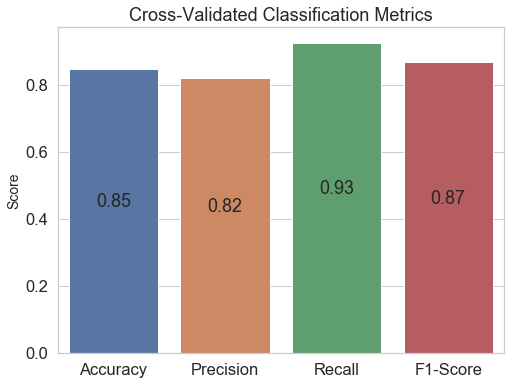

In [68]:
# Visualize cross-validated matrix
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
cv_metric = sns.barplot(data=cv_metric_df)
for p in cv_metric.patches:
    cv_metric.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("Score", size=14)
plt.title("Cross-Validated Classification Metrics");

### Feature Importance 
    Which feature contributed most to the outcomes of the model and how did they contribute?


In [69]:
# Fit an instance of Logistic Regression 
clf = LogisticRegression(C = 0.20565123083486536, solver = "liblinear")
clf.fit(X_train, y_train);
# Check coeff_
clf.coef_

array([[ 0.00319924, -0.86313351,  0.66127318, -0.01156812, -0.00166163,
         0.04355888,  0.31487019,  0.02461393, -0.60586029, -0.56860574,
         0.45182686, -0.63590762, -0.67978937]])

In [70]:
# Match coef's of feature to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031992427494907947,
 'sex': -0.8631335136081748,
 'cp': 0.6612731817103128,
 'trestbps': -0.011568115564302954,
 'chol': -0.0016616270808191324,
 'fbs': 0.043558876764809906,
 'restecg': 0.3148701873614556,
 'thalach': 0.02461393412557196,
 'exang': -0.6058602864971772,
 'oldpeak': -0.5686057412593252,
 'slope': 0.4518268594038065,
 'ca': -0.6359076156242102,
 'thal': -0.6797893708001093}

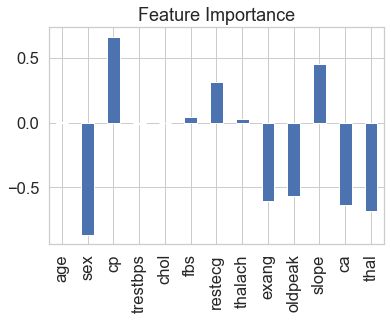

In [71]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

## Explore

We can see that sex is fairly negatively correlated as it is almost at the bottom. It means that when the value for the sex increases the target value decreases beacuse of the negative coefficent. 

In [72]:
pd.crosstab(df["sex"], df["target"])

target,0,1
sex,,
0,24,72
1,114,93


However, it does not makes sense based on the crosstab result. After looking at this, we see that the ratio is what we were thinking about. So as sex goes up, the target value ratio decreases. For example, if the sex is zero for female there is almost three to one ratio. And then as sex increases, the target goes down to about a 1 to 2  ratio. It's a negative correlation which means that sex is a negative coefficent. 


Now let's look at a positive coefficent --- Slope

We see that as slope increases the target should also increase as well because it is a positive coefficient. 

In [73]:
pd.crosstab(df["slope"], df["target"])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


There are three values for slope 0, 1 and 2. So as it increases, the number of samples in the target columns also increases

## Conclussion

The goal was to obtain 95% accuracy report but we hitted almost 88.5%. If we want to improve the evalution metric in future we can come back to this project and do the following:

    * Collect more data if possible
    * Try a better scikit learn model. For example CatBoost or XGBoost
    
But this far, we will accept our models and finish this off for now. 